In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext dotenv

%dotenv ../../env/.env

import warnings
import utils
from pandas import Timedelta
import time
from utils import logger, sql_to_df, run_sql, session, conn
import pandas as pd
warnings.filterwarnings('ignore')

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

07:35:19 INFO:Snowflake Connector for Python Version: 2.7.12, Python Version: 3.8.16, Platform: macOS-10.15.7-x86_64-i386-64bit
07:35:19 INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
07:35:20 INFO:Snowflake Connector for Python Version: 2.7.12, Python Version: 3.8.16, Platform: macOS-10.15.7-x86_64-i386-64bit
07:35:20 INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
07:35:21 INFO:Snowpark Session information: 
"version" : 1.3.0,
"python.version" : 3.8.16,
"python.connector.version" : 2.7.12,
"python.connector.session.id" : 41511443048018,
"os.name" : Darwin



connected to RAKUTENUSA-EBATES USAGE_MONITOR_1_WH
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.4 ms (started: 2023-04-13 19:35:21 -04:00)


In [7]:
# %conda install python-dotenv
# %conda install snowflake-connector-python[pandas]
# %conda install pandas
# %conda install plotly
# %conda install snowflake-snowpark-python

time: 260 µs (started: 2023-04-13 10:29:57 -04:00)


In [99]:
schema = 'sandbox'
run_sql(f"use schema {schema}")
session.sql(f"use schema {schema}").collect()

07:18:58 INFO:running sql: use schema sandbox
07:18:58 INFO:query: [use schema sandbox]
07:18:59 INFO:query execution done
07:18:59 INFO:query: [use schema sandbox]
07:18:59 INFO:query execution done


[Row(status='Statement executed successfully.')]

time: 1.02 s (started: 2023-04-13 19:18:58 -04:00)


In [12]:
# warehouse_ids = [41,42,43]
warehouse_ids = [38,39,40]
joined = ','.join([str(w) for w in warehouse_ids])
sql_str = f"({joined})"

sql = f"""
select 
    warehouse_id, 
    era_start, 
    era_end
from query_era

-- where warehouse_id in {sql_str}
order by era_start asc
"""

# where warehouse_id in (
#     select warehouse_id from (
#         select top 10
#             warehouse_id,
#             warehouse_name,
#             sum(dollars_used)
#         from warehouse_metering_history_enriched
#         group by 1,2 order by 3 desc
#     )
df = sql_to_df(sql)
display(df)
polling_sec = 1

def greedy_suspend(query_eras, autosuspend_sec):
    started = False
    resumed_on = None
    previous_end = None
    dt = Timedelta(seconds=autosuspend_sec)
    events = []
    for (start, end) in query_eras:
        # first process events between previous_end and start
        # suspend happens at: 
        # previous_end + 2*polling_period, as long as we're after resumed_on + 60 + 2*polling_period, 
        if started:
            timediff = start - previous_end 
            if timediff > dt:
                suspend_time = previous_end + dt
                started = False
                events.append((suspend_time, 'suspend'))

        if not started:
            started = True
            resumed_on = start
            events.append((resumed_on, 'resume'))

        previous_end = end
    
    if started:
        suspend_time = previous_end + dt
        started = False
        events.append((suspend_time, 'suspend')) 
        
    events_df = pd.DataFrame(events, columns=['timestamp', 'event_type'])
    return events_df

def snowflake_suspend(query_eras, autosuspend_sec):
#     dt = Timedelta(seconds=autosuspend_sec)
#     sixty = Timedelta(seconds=60)
    return greedy_suspend(query_eras, max(autosuspend_sec, 30))

def smart_suspend(query_eras, polling_sec):
    started = False
    running = 0
    resumed_on = None

    previous_end = None
    resumed_plus_sixty = None
    events = []
    for (start, end) in query_eras:
        
        # first process events between previous_end and start
        # suspend happens at: 
        # previous_end + 2*polling_period, as long as we're after resumed_on + 60 + 2*polling_period, 

        if started:
            first_check_after_previous_end = previous_end + 2*Timedelta(seconds=polling_sec)
            earliest_possible_suspend = max(first_check_after_previous_end, resumed_plus_sixty)
            if earliest_possible_suspend < start:
                started = False
                events.append((earliest_possible_suspend, 'suspend'))

        if not started:
            started = True
            resumed_on = start
            resumed_plus_sixty = resumed_on + Timedelta(seconds=60)
            events.append((resumed_on, 'resume'))

        previous_end = end
    
    if started:
        first_check_after_previous_end = previous_end + 2*Timedelta(seconds=polling_sec)
        earliest_possible_suspend = max(first_check_after_previous_end, resumed_plus_sixty)
        events.append((earliest_possible_suspend, 'suspended'))


    events_df = pd.DataFrame(events, columns=['timestamp', 'event_type'])
    return events_df

warehouse_event_dfs = []
for warehouse_id in df.warehouse_id.unique():
    print(warehouse_id)
    wh_df = df[df.warehouse_id == warehouse_id].sort_values('era_start', ascending=True)
    
    eras = list(zip(wh_df.era_start, wh_df.era_end))
    
    strategy = {'type': 'greedy_after_one_min', 'polling_sec': polling_sec}

    events_df = smart_suspend(eras, polling_sec)
    events_df['strategy'] = str(strategy)
    events_df['warehouse_id'] = warehouse_id
    warehouse_event_dfs.append(events_df)

    # autosuspend_sec = 60
    for autosuspend_sec in [30, 60, 120]:

        strategy = {'type': 'greedy', 'autosuspend_sec': autosuspend_sec}
        # print(strategy)
        events_df = greedy_suspend(eras, autosuspend_sec)
        events_df['strategy'] = str(strategy)
        events_df['warehouse_id'] = warehouse_id
        warehouse_event_dfs.append(events_df)

        strategy = {'type': 'snowflake', 'autosuspend_sec': autosuspend_sec}
        # print(strategy)
        events_df = snowflake_suspend(eras, autosuspend_sec)
        events_df['strategy'] = str(strategy)
        events_df['warehouse_id'] = warehouse_id
        warehouse_event_dfs.append(events_df)

final_df = pd.concat(warehouse_event_dfs)

final_df


10:36:54 INFO:query: [select warehouse_id, era_start, era_end from query_era  -- where warehouse_id in...]


using arrow to fetch results...


10:36:58 INFO:query execution done


,warehouse_id,era_start,era_end
0,169,2023-01-04 22:39:51.689000-08:00,2023-01-04 22:40:12.414000-08:00
1,104,2023-01-04 22:39:55.959000-08:00,2023-01-04 22:39:56.364000-08:00
2,123,2023-01-04 22:40:02.277000-08:00,2023-01-04 22:41:07.663000-08:00
3,128,2023-01-04 22:40:05.850000-08:00,2023-01-04 22:40:07.386000-08:00
4,36,2023-01-04 22:40:08.066000-08:00,2023-01-04 22:40:10.406000-08:00
...,...,...,...
3516073,144,2023-04-11 23:59:43.710000-07:00,2023-04-11 23:59:44.501000-07:00
3516074,144,2023-04-11 23:59:45.627000-07:00,2023-04-11 23:59:45.754000-07:00
3516075,169,2023-04-11 23:59:47.673000-07:00,2023-04-11 23:59:48.481000-07:00
3516076,212,2023-04-11 23:59:52.324000-07:00,2023-04-11 23:59:52.869000-07:00


169
104
123
128
36
144
139
101
187
173
49
24
212
210
102
247
211
97
228
116
148
77
201
93
75
58
122
80
105
108
229
133
53
200
145
236
202
7
209
57
182
248
175
25
190
231
235
111
193
152
138
61
50
154
65
115
125
204
56
60
221
91
150
165
249
64
45
78
63
66
163
205
155
68
180
34
47
177
166
51
143
107
167
72
196
176
142
214
137
95
230
224
124
69
52
242
130
46
220
73
156
141
238
188
132
71
253
223
54
140
208
146
199
119
257
189
245
246
239
237
4
258
222
213
192
256
136
217
261
225
147
185
262
263
264
174


,timestamp,event_type,strategy,warehouse_id
0,2023-01-04 22:39:51.689000-08:00,resume,"{'type': 'greedy_after_one_min', 'polling_sec'...",169
1,2023-01-04 22:44:34.146000-08:00,suspend,"{'type': 'greedy_after_one_min', 'polling_sec'...",169
2,2023-01-04 22:45:30.369000-08:00,resume,"{'type': 'greedy_after_one_min', 'polling_sec'...",169
3,2023-01-04 22:46:30.369000-08:00,suspend,"{'type': 'greedy_after_one_min', 'polling_sec'...",169
4,2023-01-04 22:49:28.002000-08:00,resume,"{'type': 'greedy_after_one_min', 'polling_sec'...",169
...,...,...,...,...
1,2023-04-11 15:40:03.644000-07:00,suspend,"{'type': 'snowflake', 'autosuspend_sec': 120}",174
2,2023-04-11 15:54:39.348000-07:00,resume,"{'type': 'snowflake', 'autosuspend_sec': 120}",174
3,2023-04-11 15:56:39.544000-07:00,suspend,"{'type': 'snowflake', 'autosuspend_sec': 120}",174
4,2023-04-11 16:45:53.541000-07:00,resume,"{'type': 'snowflake', 'autosuspend_sec': 120}",174


time: 3min 33s (started: 2023-04-13 22:36:54 -04:00)


In [66]:
final_df.strategy.unique()

,timestamp,event_type,strategy,warehouse_id
0,2023-01-11 10:23:38.524000-08:00,resumed,"{'type': 'greedy_after_one_min', 'polling_sec'...",1
1,2023-01-11 10:24:38.524000-08:00,suspended,"{'type': 'greedy_after_one_min', 'polling_sec'...",1
2,2023-01-11 10:28:40.668000-08:00,resumed,"{'type': 'greedy_after_one_min', 'polling_sec'...",1
3,2023-01-11 10:29:40.668000-08:00,suspended,"{'type': 'greedy_after_one_min', 'polling_sec'...",1
4,2023-01-11 20:46:05.351000-08:00,resumed,"{'type': 'greedy_after_one_min', 'polling_sec'...",1
...,...,...,...,...
1,2023-04-10 16:55:38.034000-07:00,suspended,"{'type': 'greedy_after_one_min', 'polling_sec'...",42
0,2023-04-10 16:54:38.034000-07:00,resumed,"{'type': 'snowflake', 'autosuspend_sec': 60, '...",42
0,2023-04-10 16:54:38.366000-07:00,resumed,"{'type': 'greedy_after_one_min', 'polling_sec'...",43
1,2023-04-10 16:55:38.366000-07:00,suspended,"{'type': 'greedy_after_one_min', 'polling_sec'...",43


time: 19.4 ms (started: 2023-04-13 16:15:42 -04:00)


In [13]:
import snowflake.snowpark.functions as F
import snowflake.snowpark.dataframe
def uppercase_all_columns(df: snowflake.snowpark.dataframe) -> snowflake.snowpark.dataframe:
    return df.select([F.col(column).as_(column.upper()) for column in df.columns])

final_df.timestamp = final_df.timestamp.map(str)

df = session.create_dataframe(final_df)
uppercase_all_columns(df).write.mode("overwrite").save_as_table("wh_events_sim_python")

11:09:44 INFO:query: [create temporary stage /* Python:snowflake.connector.pandas_tools.write_pandas()...]
11:09:46 INFO:query execution done
11:09:59 INFO:query: [PUT /* Python:snowflake.connector.pandas_tools.write_pandas() */ 'file:///var/fo...]
11:09:59 INFO:query execution done
11:10:54 INFO:query: [CREATE FILE FORMAT "zwhwj" /* Python:snowflake.connector.pandas_tools.write_pand...]
11:10:55 INFO:query execution done
11:10:55 INFO:query: [SELECT COLUMN_NAME, TYPE FROM table(infer_schema(location=>'@"qkndv"', file_form...]
11:10:56 INFO:query execution done
11:10:56 INFO:query: [CREATE TEMPORARY TABLE IF NOT EXISTS "PLATFORM_OPS"."SNOWFLAKE_USAGE"."SNOWPARK_...]
11:10:57 INFO:query execution done
11:10:57 INFO:query: [DROP FILE FORMAT IF EXISTS "zwhwj"]
11:10:57 INFO:query execution done
11:10:57 INFO:query: [COPY INTO "PLATFORM_OPS"."SNOWFLAKE_USAGE"."SNOWPARK_TEMP_TABLE_SO8XFPEU8E" /* P...]
11:11:35 INFO:query execution done
11:11:35 INFO:query: [SELECT  *  FROM ("PLATFORM_OPS"."

time: 2min 24s (started: 2023-04-13 23:09:18 -04:00)


In [14]:
df.schema

StructType([StructField('"timestamp"', StringType(), nullable=True), StructField('"event_type"', StringType(), nullable=True), StructField('"strategy"', StringType(), nullable=True), StructField('"warehouse_id"', LongType(), nullable=True)])

time: 2.3 ms (started: 2023-04-13 23:11:43 -04:00)


In [46]:
sql = """
with query_era as (
    select * from sandbox.query_era
),
range as (
    select 
        min(era_start) as min, 
        max(era_end) as max,
        timediff(seconds, min, max) as num_seconds
    from query_era

)
-- select * from range;
,
seconds as (
    select
        dateadd(
            'second',
            '-' || row_number() over (order by seq4() asc),
            dateadd('second', '+1', date_trunc('second', current_timestamp()))
        ) as second_start
        
        -- dateadd('second', '+1', second_start) as second_end
        
    from table(generator(rowcount => (3600*24 * 100)))
),
seconds_limited as (
    select second_start as timestamp
    from seconds
    where 
        timestamp >= date_trunc(second, (select min from range)) and 
        timestamp <= date_trunc(second, (select max from range))  

),
eras_per_second as (
-- select * from query_era;
select
    seconds.timestamp,
    count(era_start) as eras_found
from seconds_limited seconds
left join query_era as era
    on date_trunc('hour', seconds.timestamp) = date_trunc('hour', era.era_start) -- NEW: equi-join condition
    -- and seconds.warehouse_id = queries.warehouse_id
    and seconds.timestamp -- range join condition
      between date_trunc('second', era.era_start) and date_trunc('second', era.era_end)
group by 1
)
select *
from eras_per_second
order by timestamp asc;
"""
df = sql_to_df(sql)
df

10:01:20 INFO:query: [with query_era as ( select * from sandbox.query_era ), range as ( select min(era...]


using arrow to fetch results...


10:01:25 INFO:query execution done


,timestamp,eras_found
0,2023-01-03 06:01:21-08:00,0
1,2023-01-03 06:01:22-08:00,0
2,2023-01-03 06:01:23-08:00,0
3,2023-01-03 06:01:24-08:00,0
4,2023-01-03 06:01:25-08:00,0
...,...,...
1792466,2023-01-23 23:55:47-08:00,1
1792467,2023-01-23 23:55:48-08:00,1
1792468,2023-01-23 23:55:49-08:00,1
1792469,2023-01-23 23:55:50-08:00,1


time: 7.29 s (started: 2023-04-13 10:01:20 -04:00)


In [23]:


# state = list(zip(df.timestamp, df.eras_found))

# def wh_events_simulated(wh_activity_series):
started = False
events = []
for (ts, active) in state:
    # simulate auto-resume
    if active and not started:
        started = True
        resumed_on = ts
        events.append((ts, 'resumed'))
        # logger.info(f"resumed on {ts}")

    time_since_resumed = ts - resumed_on

    # smart shutdown
    if started:
        if (not active) and time_since_resumed >= Timedelta(seconds=60):
            started = False
            # logger.info(f"suspended on {ts}")
            events.append((ts, 'suspended'))

events_df = pd.DataFrame(events, columns=['ts', 'type'])
# return events_df

time: 8.65 s (started: 2023-04-13 02:23:09 -04:00)


In [29]:
conn.schema

'ANALYTICS'

time: 1.73 ms (started: 2023-04-13 14:57:05 -04:00)


In [32]:
suspend_lags_sql = """
with eras as (
    select
        'query' as type,
        warehouse_id,
        warehouse_name,
        era_start,
        era_end
    from query_era

    union

    select
        'warehouse'as type,
        warehouse_id,
        warehouse_name,
        era_start,
        era_end
    from warehouse_era
    where era_start > (select min(era_start) from query_era)
),
enriched as (
    select 
        row_number() over(order by warehouse_id, era_end) as era_id,
        *,
        -- max(era_end) over (partition by warehouse_id)
        lag(type) over (partition by warehouse_id order by era_end) as previous_ending_type,
        lag(era_end) over (partition by warehouse_id order by era_end) as previous_ending_time,
        case when type = 'warehouse' and previous_ending_type = 'query' then timediff(milliseconds, previous_ending_time, era_end)/1000 else null end as suspend_lag,
        case when type = 'query' and previous_ending_type = 'query' then timediff(milliseconds, previous_ending_time, era_start)/1000 else null end as time_since_last_query,
        timediff(seconds, era_start, era_end) as era_seconds
    from eras
)
select * from enriched
"""

df = sql_to_df(suspend_lags_sql)


02:58:09 INFO:query: [with eras as ( select 'query' as type, warehouse_id, warehouse_name, era_start, ...]


using arrow to fetch results...


02:58:10 INFO:query execution done


time: 2.38 s (started: 2023-04-13 14:58:09 -04:00)


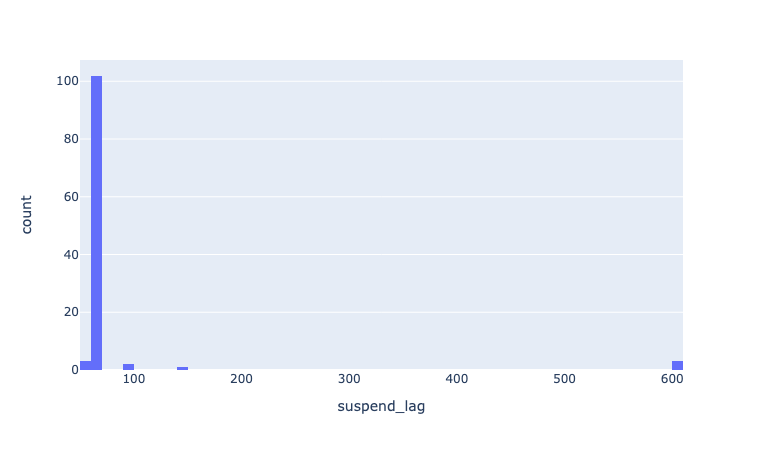

time: 52.5 ms (started: 2023-04-13 15:06:09 -04:00)


In [37]:

import plotly.express as px
px.histogram(df[df.warehouse_name == 'DEMO_SMALL'], 'suspend_lag')

In [11]:

warehouses_strategies = [
    ("autosuspend_sixty", "autosuspend_sixty"),
    ("smartsuspend_ten", "smartsuspend_ten"),
    ("suspend_ten", "suspend_ten"),
    # ("demo", "suspend_ten")
]

while True:
    time.sleep(1)
    logger.info("\n=======================================================================================================\n")

    for (wh, strategy) in warehouses_strategies:
        df = sql_to_df(f"show warehouses like '{wh}'")
        logger.info(f"warehouse {wh}")
        if (len(df) == 0):
            logging.info("not found")
            continue
        status = df.iloc[0].to_dict()
        state = status['state']
        running = status['running']
        queued = status['queued']
        inactive = (running + queued) == 0
        time_since_resumed = pd.Timestamp.utcnow() - status['resumed_on']
        logger.info(f"state {state} | running {running} | queued {queued} | inactive {inactive} | time_since_resumed {time_since_resumed}")
        logger.info("---------------------------------------------------------------------------------------------------------------")
        if state == 'STARTED':

            # if wh == 'autosuspend_sixty':
            #     logging.info("doing nothing")

            if strategy == "suspend_ten":
                if inactive:
                    run_sql(f"ALTER WAREHOUSE {wh} SUSPEND")

            if strategy == "smartsuspend_ten":
                if inactive and time_since_resumed >= Timedelta(seconds=60):
                    run_sql(f"ALTER WAREHOUSE {wh} SUSPEND")

    


11:12:19 INFO:

11:12:19 INFO:query: [show warehouses like 'autosuspend_sixty']
11:12:19 INFO:query execution done
11:12:19 INFO:warehouse autosuspend_sixty
11:12:19 INFO:state SUSPENDED | running 0 | queued 0 | inactive True | time_since_resumed 0 days 15:17:42.337345
11:12:19 INFO:---------------------------------------------------------------------------------------------------------------
11:12:19 INFO:query: [show warehouses like 'smartsuspend_ten']
11:12:20 INFO:query execution done
11:12:20 INFO:warehouse smartsuspend_ten
11:12:20 INFO:state SUSPENDED | running 0 | queued 0 | inactive True | time_since_resumed 0 days 15:17:42.341450
11:12:20 INFO:---------------------------------------------------------------------------------------------------------------
11:12:20 INFO:query: [show warehouses like 'suspend_ten']
11:12:20 INFO:query execution done
11:12:20 INFO:warehouse suspend_ten
11:12:20 INFO:state SUSPENDED | running 0 | queued 0 | inactive True | time_since_resumed 0 days 

KeyboardInterrupt: 

In [37]:
status['resumed_on']

Timestamp('2023-04-10 06:25:23.645000+0000', tz='UTC')

In [9]:
from datetime import datetime
datetime.now()

datetime.datetime(2023, 4, 9, 19, 20, 6, 205087)

In [22]:
import pandas as pd
pd.Timestamp.utcnow() - status['resumed_on']

Timedelta('0 days 00:00:11.437963')